In [1]:
from utils import KnuthMorrisPratt
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import scipy
import math
import pandas as pd
from sklearn import metrics

In [2]:
root_logdir = './'
models = sorted([f for f in os.listdir(root_logdir) if os.path.isdir(os.path.join(root_logdir, f))])
no_samples = 1000       # number of data points samples for ROC analysis (1000 hours)
window_in_minutes = 60    
th_percentile = 99

In [3]:
def plot_roc(fpr, tpr, roc_auc, animal, title):
    lw = 2
    if "326" in animal:
        plt.plot(fpr, tpr,
                lw=lw, label=animal+' (area = %0.2f)' % roc_auc, linestyle='--')
    else:
        plt.plot(fpr, tpr,
                lw=lw, label=animal+' (area = %0.2f)' % roc_auc)        
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC \n'+title)
    plt.legend(loc="lower right")

In [7]:

y_s = []
no_v_re_s = []
no_e_re_s = []
no_v_d_s = []
no_e_d_s = []


for model_name in models:
    print('working on: '+model_name)
    animal = model_name[40:]
    run_logdir = root_logdir + model_name
    output_directory = run_logdir +  '/stats/'
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)

    # training data reconstruction errors pooled across animals
    whole_segment_t_errors = np.load(output_directory+'train_data/whole_segment_t_errors.npy')
    # test animal baseline data reconstruction errors 
    whole_segment_v_errors = np.load(output_directory+'valid_data/whole_segment_v_errors.npy')
    # test animal epileptogenesis data reconstruction errors pooled across animals
    whole_segment_e_errors = np.load(output_directory+'epg_data/whole_segment_e_errors.npy')

    # same for distances to the origin of the latent prior distribution used in training
    d_t = np.load(output_directory+'train_data/distances.npy')
    d_v = np.load(output_directory+'valid_data/distances.npy')
    d_e = np.load(output_directory+'epg_data/distances.npy')

    # computing the thresholds
    th99 = np.percentile(whole_segment_t_errors, th_percentile)
    th99_d = np.percentile(d_t, th_percentile)

    
    window = int((window_in_minutes*60)/1)

    # computing the reconstruction error anomaly score for every hour in the recording baseline and epileptogenesis
    r = np.where(whole_segment_v_errors>th99, 1, 0)
    frequency_v = pd.Series(r).rolling(window).sum().dropna().values
    r = np.where(whole_segment_e_errors>th99, 1, 0)
    frequency_e = pd.Series(r).rolling(window).sum().dropna().values

    # computing the distance anomaly score for every hour in the recording baseline and epileptogenesis
    r = np.where(d_v>th99_d, 1, 0)
    frequency_v_d = pd.Series(r).rolling(window).sum().dropna().values
    r = np.where(d_e>th99_d, 1, 0)
    frequency_e_d = pd.Series(r).rolling(window).sum().dropna().values


    # randomly sampling 1000 hours from each period (baseline and epileptogenesis)
    idx_v = np.random.choice(frequency_v.shape[0], no_samples)
    idx_e = np.random.choice(frequency_e.shape[0], no_samples)
    no_v_re = frequency_v[idx_v]
    no_e_re = frequency_e[idx_e]
    no_v_d = frequency_v_d[idx_v]
    no_e_d = frequency_e_d[idx_e]


    no_v_re_s.append(no_v_re)
    no_e_re_s.append(no_e_re)
    no_v_d_s.append(no_v_d)
    no_e_d_s.append(no_e_d)

    # creating a ground truth label vector
    y = list(np.zeros(no_samples*1))+list(np.ones(no_samples*1))
    y_s.append(y)

working on: run_EPG_anomaly_2021_03_10-12_56_LOO_16_1275
working on: run_EPG_anomaly_2021_03_10-12_57_LOO_22_32140
working on: run_EPG_anomaly_2021_03_10-12_57_LOO_53_3263
working on: run_EPG_anomaly_2021_03_10-13_11_LOO_33_1227
working on: run_EPG_anomaly_2021_03_10-22_45_LOO_02_3266
working on: run_EPG_anomaly_2021_03_11-00_12_LOO_23_1276
working on: run_EPG_anomaly_2021_03_11-01_45_LOO_00_1237
working on: run_EPG_anomaly_2021_03_11-02_08_LOO_25_32141
working on: run_EPG_anomaly_2021_03_11-10_20_LOO_09_3267
working on: run_EPG_anomaly_2021_03_12-16_42_LOO_18_1270


In [18]:
aucs=[]
fprs = []
tprs = []

for k, model_name in enumerate(models):
    animal = model_name[40:]
    no_v_re = no_v_re_s[k]
    no_e_re = no_e_re_s[k]
    
    no_v_d = no_v_d_s[k]
    no_e_d = no_e_d_s[k]

    y = y_s[k]
    
    # computing the weighted average anomaly score
    re_contrib = 0.8
    no_v = re_contrib*no_v_re + (1 - re_contrib)*no_v_d
    no_e = re_contrib*no_e_re + (1 - re_contrib)*no_e_d

    # calculating false nd true positive rates for roc curves plotting
    fpr, tpr, thresholds = metrics.roc_curve(y, list(no_v)+list(no_e))
    
    roc_auc = metrics.auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)


In [19]:
fprs = np.array(fprs)
tprs = np.array(tprs)

In [11]:
figures_folder = '../figures2/'

In [12]:
control_mask = ['326' in x for x in models]
pps_mask = ['326' not in x for x in models]

In [13]:
models = np.array(models)
aucs = np.array(aucs)

In [14]:
cm = 1/2.54

labels_font = 10
legend_font = 8
ticks_font = 8
title_font = 12

In [15]:
mapping = {'1227': 'PPS 1',
 '1237': 'PPS 2',
 '1270': 'PPS 3',
 '1275': 'PPS 4',
 '1276': 'PPS 5',
 '32140': 'PPS 6',
 '32141': 'PPS 7',
 '3263': 'Ctrl 1',
 '3266': 'Ctrl 2',
 '3267': 'Ctrl 3'}

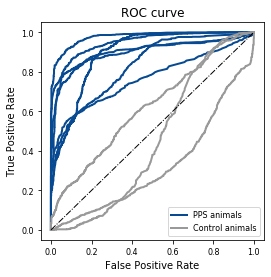

In [20]:
# plt.figure()
plt.figure(figsize=(4,4))
control_animals = models[control_mask]
pps_animals = models[pps_mask]

    
for i in range(len(fprs[pps_mask])):
    animal = pps_animals[i][40:]    
    if i==0:
        plt.plot(fprs[pps_mask][i], tprs[pps_mask][i],
                 lw=2,
                 label='PPS animals',
#                  label=mapping[animal]+' (%0.2f)' % aucs[pps_mask][i],
                 color=plt.cm.Blues(0.9))
    #              color=plt.cm.Blues(i/7+0.3))
    else:
        plt.plot(fprs[pps_mask][i], tprs[pps_mask][i],
                 lw=2,
                 color=plt.cm.Blues(0.9))
        
for i in range(len(fprs[control_mask])):
    animal = control_animals[i][40:]
    if i==0:
        plt.plot(fprs[control_mask][i], tprs[control_mask][i],
                 lw=2,
                 label='Control animals',
#                  label=mapping[animal]+' (%0.2f)' % aucs[control_mask][i],
                 color=plt.cm.gray(0.6))
    #              color=plt.cm.Oranges(i/3+0.3))
    else:
        plt.plot(fprs[control_mask][i], tprs[control_mask][i],
                 lw=2,
                 color=plt.cm.gray(0.6))
    
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='-.')
plt.xlim([-0.05, 1.05]);
plt.ylim([-0.05, 1.05]);
plt.xlabel('False Positive Rate', fontsize=labels_font);
plt.ylabel('True Positive Rate', fontsize=labels_font);
plt.title('ROC curve', fontsize=title_font);
plt.legend(loc="lower right", fontsize=legend_font, ncol=1);
plt.xticks(fontsize=ticks_font);
plt.yticks(fontsize=ticks_font);
# plt.savefig(figures_folder+'roc.pdf',bbox_inches='tight')